In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from models import *
plt.style.use('ggplot')
%matplotlib inline

# Training Curves

Use this in a similar manner to tensorboard, to check that things are training.

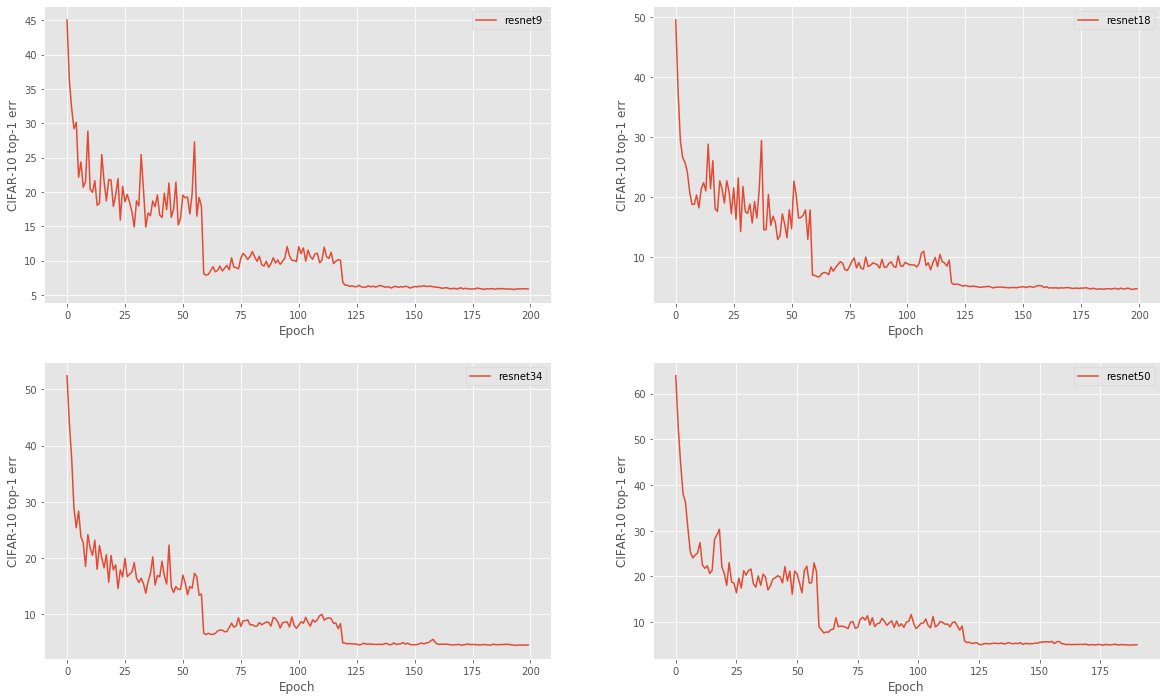

In [2]:
checkpoints = ['resnet9','resnet18','resnet34','resnet50'] # put your checkpoint files in here

cols = 2
rows = len(checkpoints) // cols

fig, axs = plt.subplots(rows,cols,figsize=(20, rows*6)) # width=20cm, height=6cm per row
axs = axs.ravel()

for checkpoint, ax in zip(checkpoints, axs):
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    ax.plot(list(range(len(sd['error_history']))), sd['error_history'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('CIFAR-10 top-1 err')
    ax.legend([checkpoint])
    
plt.show()

Given a family of ResNets we can extract a Pareto curve of accuracy vs. number of parameters:

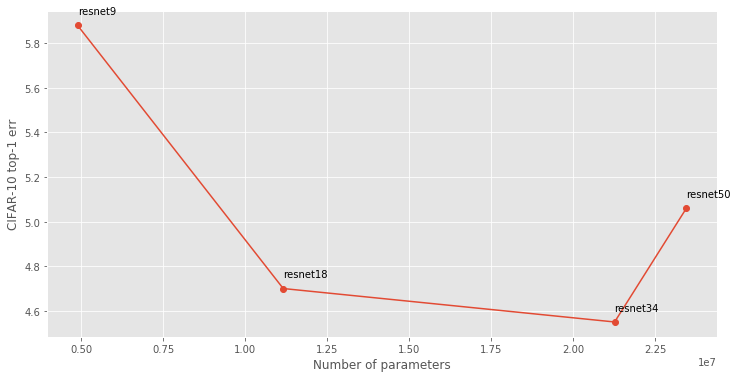

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

x = []
y = []

for checkpoint in checkpoints:
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    
    x_  = get_no_params(sd['net'])
    y_  = sd['error_history'][-1]
    x.append(x_)
    y.append(y_)
    
for i, net in enumerate(checkpoints):
    offset = 0.05
    ax.annotate(net, (x[i]+offset, y[i]+offset))    

    
ax.set_xlabel('Number of parameters')
ax.set_ylabel('CIFAR-10 top-1 err')
ax.plot(x,y, marker='o')
plt.show()


You can see immediately that ResNet-50 is over-parameterised for a small task like CIFAR-10. One could employ some more training tricks, but for fairness I will just consider the "Pareto frontier" to be ResNet-9-18-34.

The idea proposed in Han et al. is that we can beat this Pareto frontier by keeping the network structure the same but removing individual weights.

# Pruning Curves

Check that the model is pruning correctly. 

KeyboardInterrupt: 

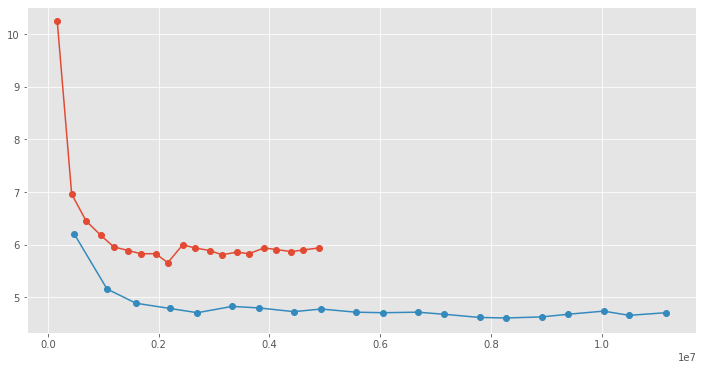

In [8]:
fig,ax      = plt.subplots(figsize=(12,6))
prune_rates = np.arange(0,100,step=5)
checkpoints = ['resnet9','resnet18','resnet34']

def get_nonzeros(sd):
    tot = 0
    for mask in sd['masks']:
        tot += torch.sum(mask!=0)
    return tot

for checkpoint in checkpoints:
    x = []
    y = []
    for prune_rate in prune_rates:
        sd = torch.load('checkpoints/%s.t7' % str(checkpoint + '_l1_' + str(prune_rate)), map_location='cpu')
        x.append(get_nonzeros(sd))
        y.append(sd['error_history'][-1])
    ax.plot(x,y,marker='o')

x = []
y = []

for checkpoint in checkpoints:
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    
    x_  = get_no_params(sd['net'])
    y_  = sd['error_history'][-1]
    x.append(x_)
    y.append(y_)
    
for i, net in enumerate(checkpoints):
    offset = 0.1
    ax.annotate(net, (x[i]+offset, y[i]+offset))    
ax.plot(x,y, marker='o')

ax.set_xlabel('Num nonzero params')
ax.set_ylabel('Top-1 Error (%)')
plt.show()

# Structured vs. Unstructured Pruning

As far as I am aware, the question of whether sparse networks learn better feature extractors than dense ones remains open. 

Here we briefly compare Fisher-pruned models to our L1-pruned models. 

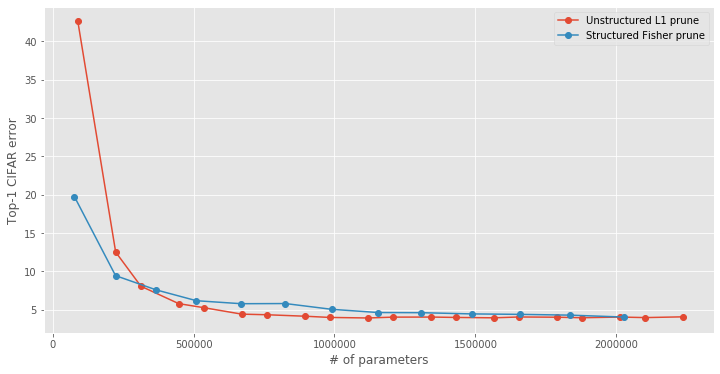

In [30]:

def get_inf_params(net, verbose=True, sd=False):
    if sd:
        params = net
    else:
        params = net.state_dict()
    tot = 0
    conv_tot = 0
    for p in params:
        no = params[p].view(-1).__len__()

        if ('num_batches_tracked' not in p) and ('running' not in p) and ('mask' not in p):
            tot += no

            if verbose:
                print('%s has %d params' % (p, no))
        if 'conv' in p:
            conv_tot += no

    if verbose:
        print('Net has %d conv params' % conv_tot)
        print('Net has %d params in total' % tot)

    return tot

fig, ax = plt.subplots(figsize=(12,6))
baselines = ['wrn_40_2_1'] # ,'wrn_40_2_2','wrn_40_2_3','wrn_40_2_4','wrn_40_2_5']
sparse_prune_rates = np.arange(0,100,step=5)

## sparse prune
for baseline in baselines:
    x = []
    y = []
    for prune_rate in sparse_prune_rates:
        sd = torch.load('checkpoints/%s.t7' % str(baseline + '_l1_' + str(prune_rate)), map_location='cpu')
        x.append(get_nonzeros(sd))
        y.append(sd['error_history'][-1])
    ax.plot(x,y,marker='o',label='Unstructured L1 prune')
    
    
dense_prune_rates = np.arange(100,1300,step=100)


x = [77202, 223274, 367618, 510234, 669122, 825850, 989778, 1154570, 1306608, 1486746, 1658594, 1835050, 2026338]
y = [19.760, 9.450, 7.590,  6.180,  5.790,  5.810,  5.060,  4.640,   4.620,   4.460,   4.400,   4.300,   4.050]
ax.plot(x,y, marker='o', label='Structured Fisher prune')
ax.set_xlabel('# of parameters')
ax.set_ylabel('Top-1 CIFAR error')
    
ax.legend()
plt.show()

In [33]:
sd = torch.load('checkpoints/spruning_paper/wrn_402_1.t7', map_location='cpu')
model = WideResNet(40,2)
new_sd = model.state_dict()
old_sd = sd['state_dict']

k_new = [k for k in new_sd.keys() if 'mask' not in k]
k_new = [k for k in k_new if 'num_batches_tracked' not in k]
for o, n in zip(old_sd.keys(), k_new):
    new_sd[n] = old_sd[o]
    
model.load_state_dict(new_sd)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

2243546